<a href="https://colab.research.google.com/github/Habibahalya/Deep-learning-lanjut/blob/main/Naural_Style_Transfer_DPL_Habibah_Alya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- MOUNTING GOOGLE DRIVE ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive berhasil di-Mount. Lanjutkan ke langkah berikutnya.

--- Memuat Gambar Utama dan Gaya ---


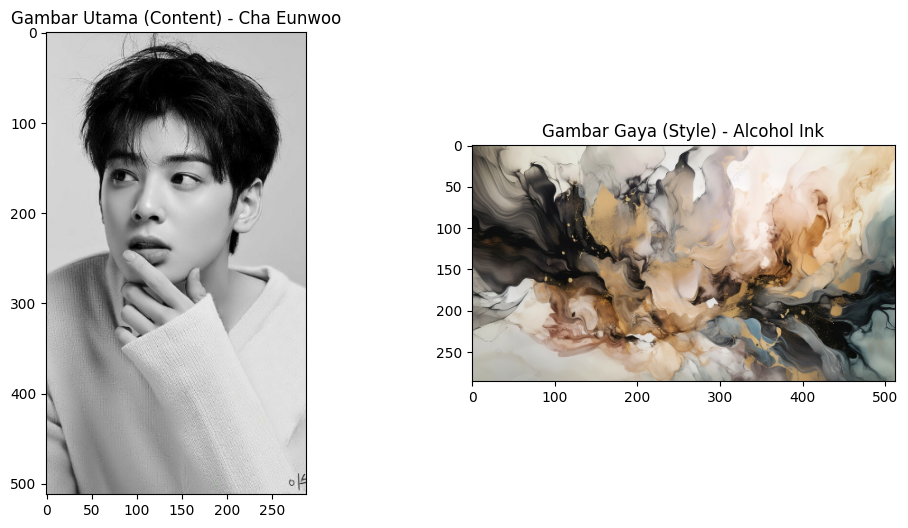


--- Memulai Style Transfer: 1000 Langkah ---
Epoch 1/10 selesai. Total langkah: 100
Epoch 2/10 selesai. Total langkah: 200
Epoch 3/10 selesai. Total langkah: 300
Epoch 4/10 selesai. Total langkah: 400
Epoch 5/10 selesai. Total langkah: 500
Epoch 6/10 selesai. Total langkah: 600
Epoch 7/10 selesai. Total langkah: 700
Epoch 8/10 selesai. Total langkah: 800
Epoch 9/10 selesai. Total langkah: 900
Epoch 10/10 selesai. Total langkah: 1000

Style Transfer Selesai dalam waktu: 4947.04 detik.

--- Hasil Style Transfer ---


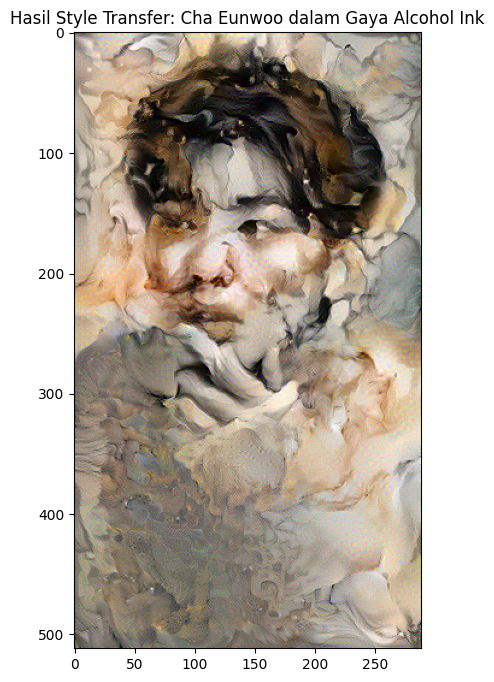


**File hasil telah tersimpan di Google Drive Anda pada jalur: /content/drive/MyDrive/deep learning lanjut/hasil_style_transfer_cha_eunwoo.png**


In [10]:
import tensorflow as tf
import IPython.display as display
from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np
import time

# Import model VGG19 (Pre-trained)
from tensorflow.keras.applications import vgg19

# --- 0. MOUNT GOOGLE DRIVE ---
# Anda harus menjalankan ini di Colab dan mengikuti instruksi otorisasi
print("--- MOUNTING GOOGLE DRIVE ---")
drive.mount('/content/drive')
print("Google Drive berhasil di-Mount. Lanjutkan ke langkah berikutnya.")

# --- 1. Definisi Jalur Gambar dan Hyperparameters ---

# **JALUR GAMBAR DARI GOOGLE DRIVE ANDA**
# Pastikan folder dan nama file sudah benar di Drive.
content_path = '/content/drive/MyDrive/deep learning lanjut/85bbdbcfd902a42202c9eae406ca0ea7.jpg'
style_path = '/content/drive/MyDrive/deep learning lanjut/pngtree-abstract-painting-composed-of-coffee-image_2604549.jpg'

# Hyperparameters
epochs = 10
steps_per_epoch = 100
total_steps = epochs * steps_per_epoch

# Bobot (Sesuaikan jika hasil terlalu buram atau terlalu mempertahankan konten)
content_weight = 1e3
style_weight = 1e-2

# Ukuran gambar yang akan diproses
img_size = 512

# --- 2. Fungsi untuk Memuat dan Memproses Gambar ---

def load_img(path_to_img):
    """Memuat gambar, mengubah ukurannya, dan mengonversinya menjadi Tensor."""
    try:
        max_dim = img_size
        img = tf.io.read_file(path_to_img)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)

        shape = tf.cast(tf.shape(img)[:-1], tf.float32)
        long_dim = max(shape)
        scale = max_dim / long_dim

        new_shape = tf.cast(shape * scale, tf.int32)
        img = tf.image.resize(img, new_shape)
        img = img[tf.newaxis, :]
        return img
    except Exception as e:
        # Menampilkan error yang lebih spesifik
        print(f"ERROR: Tidak dapat memuat gambar dari jalur: {path_to_img}")
        print(f"Detail Error: {e}")
        print("Pastikan file ada di folder Google Drive yang benar dan nama filenya sudah sesuai.")
        # Menghentikan eksekusi jika gagal memuat
        exit()

def imshow(image, title=None):
    """Menampilkan Tensor gambar."""
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

# --- Tampilkan Gambar Awal ---
print("\n--- Memuat Gambar Utama dan Gaya ---")

# Memuat gambar di sini. Jika gagal, program akan berhenti di fungsi load_img.
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
imshow(content_image, 'Gambar Utama (Content) - Cha Eunwoo')

plt.subplot(1, 2, 2)
imshow(style_image, 'Gambar Gaya (Style) - Alcohol Ink')
plt.show()


# --- 3. Membangun Model VGG19 dan Lapisan yang Dipilih ---

content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# These are now attributes of the StyleContentModel class
# num_content_layers = len(content_layers)
# num_style_layers = len(style_layers)

def vgg_layers(layer_names):
    """Membuat model VGG yang mengembalikan output dari lapisan yang diinginkan."""
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# --- 4. Definisi Model Gabungan (Content dan Style) ---

def gram_matrix(input_tensor):
    """Menghitung Gram Matrix sebagai representasi gaya."""
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / (num_locations)

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.num_content_layers = len(content_layers) # Fix: Add this line
        self.vgg.trainable = False

        # Inisialisasi weights untuk content dan style loss
        self.style_weight = style_weight # Ensure these are initialized
        self.content_weight = content_weight # Ensure these are initialized


    def call(self, inputs):
        """Mengeluarkan feature Content dan Gram Matrix Style."""
        inputs = inputs * 255.0
        preprocessed_input = vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)

        # Split outputs into style and content features. Content features start after all style layers.
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:]) # Fix: Correct splitting index

        style_features = [gram_matrix(style_output)
                          for style_output in style_outputs]

        content_features = [content_output
                            for content_output in content_outputs]

        return {'style': style_features, 'content': content_features}

    def content_loss(self, content_output_features, content_target_features):
        """Menghitung Content Loss."""
        return tf.add_n([tf.reduce_mean((output - target)**2)
                         for output, target in zip(content_output_features, content_target_features)]) / self.content_weight

    def style_loss(self, style_output_features, gram_target):
        """Menghitung Style Loss."""
        loss = tf.add_n([tf.reduce_mean((style_feature - gram_target[i])**2)
                         for i, style_feature in enumerate(style_output_features)])
        return loss / (self.num_style_layers * self.style_weight)


# --- 5. Inisialisasi dan Optimasi ---

# Inisialisasi Model Extractor
extractor = StyleContentModel(style_layers, content_layers)

# Ekstraksi target Content dan Style dari gambar awal
# Memanggil extractor.call() untuk mendapatkan target features
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Gambar hasil Style Transfer diinisialisasi dari gambar Content
image = tf.Variable(content_image)

# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Fungsi untuk 'menjepit' nilai piksel agar tetap di antara 0 dan 1
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Fungsi Langkah Style Transfer (Training Step)
@tf.function
def train_step(image):
    # Menggunakan tf.function untuk kecepatan, pastikan semua variabel terdefinisi di sini.
    with tf.GradientTape() as tape:
        model_outputs = extractor(image)

        style_output_features = model_outputs['style']
        content_output_features = model_outputs['content']

        # Hitung Style Loss (now correctly called as method and includes weighting internally)
        s_loss = extractor.style_loss(style_output_features, style_targets)

        # Hitung Content Loss (now correctly called as method and includes weighting internally)
        c_loss = extractor.content_loss(content_output_features, content_targets)

        # Total Loss
        loss = s_loss + c_loss

    # Gradien Loss terhadap gambar
    grad = tape.gradient(loss, image)
    # Terapkan gradien
    opt.apply_gradients([(grad, image)])
    # Jaga nilai piksel tetap valid
    image.assign(clip_0_1(image))

# --- 6. Jalankan Proses Training dan Tampilkan Hasil ---

print(f"\n--- Memulai Style Transfer: {total_steps} Langkah ---")

# Proses Training
start = time.time()
for i in range(total_steps):
    train_step(image)
    if (i + 1) % steps_per_epoch == 0:
        step = (i + 1) // steps_per_epoch
        print(f"Epoch {step}/{epochs} selesai. Total langkah: {i + 1}")

end = time.time()
print(f"\nStyle Transfer Selesai dalam waktu: {end - start:.2f} detik.")


# Tampilkan Hasil Akhir
print("\n--- Hasil Style Transfer ---")
plt.figure(figsize=(8, 8))
imshow(image, 'Hasil Style Transfer: Cha Eunwoo dalam Gaya Alcohol Ink')
plt.show()

# Simpan Hasil Akhir ke Google Drive (SANGAT PENTING untuk persistensi)
final_image = image.numpy()[0]
final_image_tensor = tf.image.convert_image_dtype(final_image, dtype=tf.uint8)

# Simpan di folder yang sama di Drive
output_path = '/content/drive/MyDrive/deep learning lanjut/hasil_style_transfer_cha_eunwoo.png'
tf.io.write_file(output_path, tf.image.encode_png(final_image_tensor))

print(f"\n**File hasil telah tersimpan di Google Drive Anda pada jalur: {output_path}**")